In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from data_preprocessing import RPEDataset

In [3]:
original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((149,149)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

cropped_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop((149, 149)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
rpe30 = RPEDataset(30, transform=original_transform)
rpe30_1 = RPEDataset(30, transform=cropped_transform)
rpe30_2 = RPEDataset(30, transform=cropped_transform)
rpe30_3 = RPEDataset(30, transform=cropped_transform)
rpe30_4 = RPEDataset(30, transform=cropped_transform)
rpe30_5 = RPEDataset(30, transform=cropped_transform)
rpe30_6 = RPEDataset(30, transform=cropped_transform)
rpe30_7 = RPEDataset(30, transform=cropped_transform)
rpe30_8 = RPEDataset(30, transform=cropped_transform)
rpe30_9 = RPEDataset(30, transform=cropped_transform)
rpe30_10 = RPEDataset(30, transform=cropped_transform)

rpe30set = ConcatDataset([rpe30, 
                          rpe30_1,
                          rpe30_2,
                          rpe30_3,
                          rpe30_4,
                          rpe30_5,
                          rpe30_6,
                          rpe30_7,
                          rpe30_8,
                          rpe30_9,
                          rpe30_10])

In [5]:
rpe45 = RPEDataset(45, transform=original_transform)
rpe45_1 = RPEDataset(45, transform=cropped_transform)
rpe45_2 = RPEDataset(45, transform=cropped_transform)
rpe45_3 = RPEDataset(45, transform=cropped_transform)
rpe45_4 = RPEDataset(45, transform=cropped_transform)

rpe45set = ConcatDataset([rpe45,
                          rpe45_1,
                          rpe45_2,
                          rpe45_3,
                          rpe45_4])

In [6]:
rpe60 = RPEDataset(60, transform=original_transform)
rpe60_1 = RPEDataset(60, transform=cropped_transform)
rpe60_2 = RPEDataset(60, transform=cropped_transform)
rpe60_3 = RPEDataset(60, transform=cropped_transform)

rpe60set = ConcatDataset([rpe60,
                         rpe60_1,
                         rpe60_2,
                         rpe60_3])

In [7]:
rpe180set = RPEDataset(180, transform=original_transform)

In [8]:
rpe330 = RPEDataset(330, transform=original_transform)
rpe330_1 = RPEDataset(330, transform=cropped_transform)
rpe330_2 = RPEDataset(330, transform=cropped_transform)

rpe330set = ConcatDataset([rpe330,
                           rpe330_1,
                           rpe330_2])

In [9]:
rpe720 = RPEDataset(720, transform=original_transform)
rpe720_1 = RPEDataset(720, transform=cropped_transform)
rpe720_2 = RPEDataset(720, transform=cropped_transform)
rpe720_3 = RPEDataset(720, transform=cropped_transform)
rpe720_4 = RPEDataset(720, transform=cropped_transform)
rpe720_5 = RPEDataset(720, transform=cropped_transform)
rpe720_6 = RPEDataset(720, transform=cropped_transform)

rpe720set = ConcatDataset([rpe720,
                           rpe720_1,
                           rpe720_2,
                           rpe720_3,
                           rpe720_4,
                           rpe720_5,
                           rpe720_6])

In [10]:
full_dataset = ConcatDataset([rpe30set,
                              rpe45set,
                              rpe60set,
                              rpe180set,
                              rpe330set,
                              rpe720set])

In [11]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 37 * 37, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
for epoch in range(10):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1.7164
Epoch 2, Loss: 1.2498
Epoch 3, Loss: 0.9930
Epoch 4, Loss: 0.9249
Epoch 5, Loss: 0.8073
Epoch 6, Loss: 0.7340
Epoch 7, Loss: 0.8163
Epoch 8, Loss: 0.6651
Epoch 9, Loss: 0.5850
Epoch 10, Loss: 0.6522


In [16]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())


Test Accuracy: 78.17%


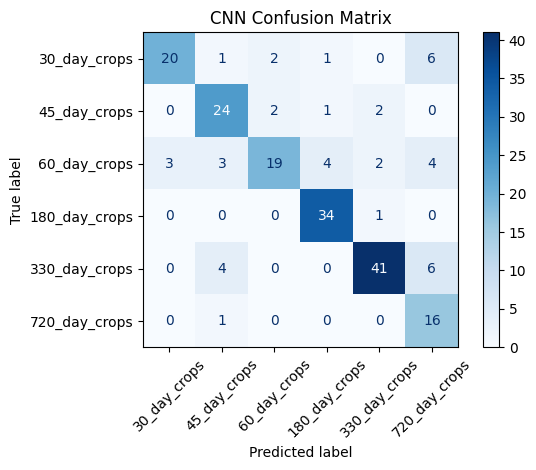

In [17]:
age_labels = ['30_day_crops', '45_day_crops', '60_day_crops', '180_day_crops', '330_day_crops', '720_day_crops']
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc * 100:.2f}%")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=age_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()
